# Building text classifier with Differential Privacy

In this tutorial we will train a text classifier with Differential Privacy by taking a model pre-trained on public text data and fine-tuning it for a different task.

When training a model with differential privacy, we almost always face a trade-off between model size and accuracy on the task. The exact details depend on the problem, but a rule of thumb is that the fewer parameters the model has, the easier it is to get a good performance with DP.

Most state-of-the-art NLP models are quite deep and large (e.g. [BERT-base](https://github.com/google-research/bert) has over 100M parameters), which makes task of training text model on a private datasets rather challenging.

One way of addressing this problem is to divide the training process into two stages. First, we will pre-train the model on a public dataset, exposing the model to generic text data. Assuming that the generic text data is public, we will not be using differential privacy at this step. Then, we freeze most of the layers, leaving only a few upper layers to be trained on the private dataset using DP-SGD. This way we can get the best of both worlds - we have a deep and powerful text understanding model, while only training a small number of parameters with differentially private algorithm.

In this tutorial we will take the pre-trained [BERT-base](https://github.com/google-research/bert) model and fine-tune it to recognize textual entailment on the [SNLI](https://nlp.stanford.edu/projects/snli/) dataset.

## Dataset

First, we need to download the dataset (we'll user Stanford NLP mirror)

In [3]:
STANFORD_SNLI_URL = "https://nlp.stanford.edu/projects/snli/snli_1.0.zip"
DATA_DIR = "data"

In [4]:
import zipfile
import urllib.request
import os

def download_and_extract(dataset_url, data_dir):
    print("Downloading and extracting ...")
    filename = "snli.zip"
    urllib.request.urlretrieve(dataset_url, filename)
    with zipfile.ZipFile(filename) as zip_ref:
        zip_ref.extractall(data_dir)
    os.remove(filename)
    print("Completed!")

download_and_extract(STANFORD_SNLI_URL, DATA_DIR)

Completed!


The dataset comes in two formats (`tsv` and `json`) and has already been split into train/dev/test. Let’s verify that’s the case.

In [5]:
snli_folder = os.path.join(DATA_DIR, "snli_1.0")
os.listdir(snli_folder)

['.DS_Store',
 'Icon\r',
 'README.txt',
 'snli_1.0_dev.jsonl',
 'snli_1.0_dev.txt',
 'snli_1.0_test.jsonl',
 'snli_1.0_test.txt',
 'snli_1.0_train.jsonl',
 'snli_1.0_train.txt']

Let's now take a look inside. [SNLI dataset](https://nlp.stanford.edu/projects/snli/) provides ample syntactic metadata, but we'll only use raw input text. Therefore, the only fields we're interested in are **sentence1** (premise), **sentence2** (hypothesis) and **gold_label** (label chosen by the majority of annotators).

Label defines the relation between premise and hypothesis: either *contradiction*, *neutral* or *entailment*.

In [6]:
import pandas as pd
train_path =  os.path.join(snli_folder, "snli_1.0_train.txt")
dev_path = os.path.join(snli_folder, "snli_1.0_dev.txt")

df_train = pd.read_csv(train_path, sep='\t')
df_test = pd.read_csv(dev_path, sep='\t')

df_train[['sentence1', 'sentence2', 'gold_label']][:5]

,sentence1,sentence2,gold_label
0,A person on a horse jumps over a broken down a...,A person is training his horse for a competition.,neutral
1,A person on a horse jumps over a broken down a...,"A person is at a diner, ordering an omelette.",contradiction
2,A person on a horse jumps over a broken down a...,"A person is outdoors, on a horse.",entailment
3,Children smiling and waving at camera,They are smiling at their parents,neutral
4,Children smiling and waving at camera,There are children present,entailment


## Model

BERT (Bidirectional Encoder Representations from Transformers) is state of the art approach to various NLP tasks. It uses a Transformer architecture and relies heavily on the concept of pre-training. 

We'll use a pre-trained BERT-base model, provided in huggingface [transformers](https://github.com/huggingface/transformers) repo.
It gives us a pytorch implementation for the classic BERT architecture, as well as a tokenizer and weights pre-trained on a public English corpus (Wikipedia).

Please follow these [installation instrucitons](https://github.com/huggingface/transformers#installation) before proceeding.

In [ ]:
from transformers import BertConfig, BertTokenizer, BertForSequenceClassification

model_name = "bert-base-cased"
config = BertConfig.from_pretrained(
    model_name,
    num_labels=3,
)
tokenizer = BertTokenizer.from_pretrained(
    "bert-base-cased",
    do_lower_case=False,
)
model = BertForSequenceClassification.from_pretrained(
    "bert-base-cased",
    config=config,
)

The model has the following structure. It uses a combination of word, positional and token *embeddings* to create a sequence representation, then passes the data through 12 *transformer encoders* and finally uses a *linear classifier* to produce the final label.
As the model is already pre-trained and we only plan to fine-tune few upper layers, we want to freeze all layers, except for the last encoder and above (`BertPooler` and `Classifier`).

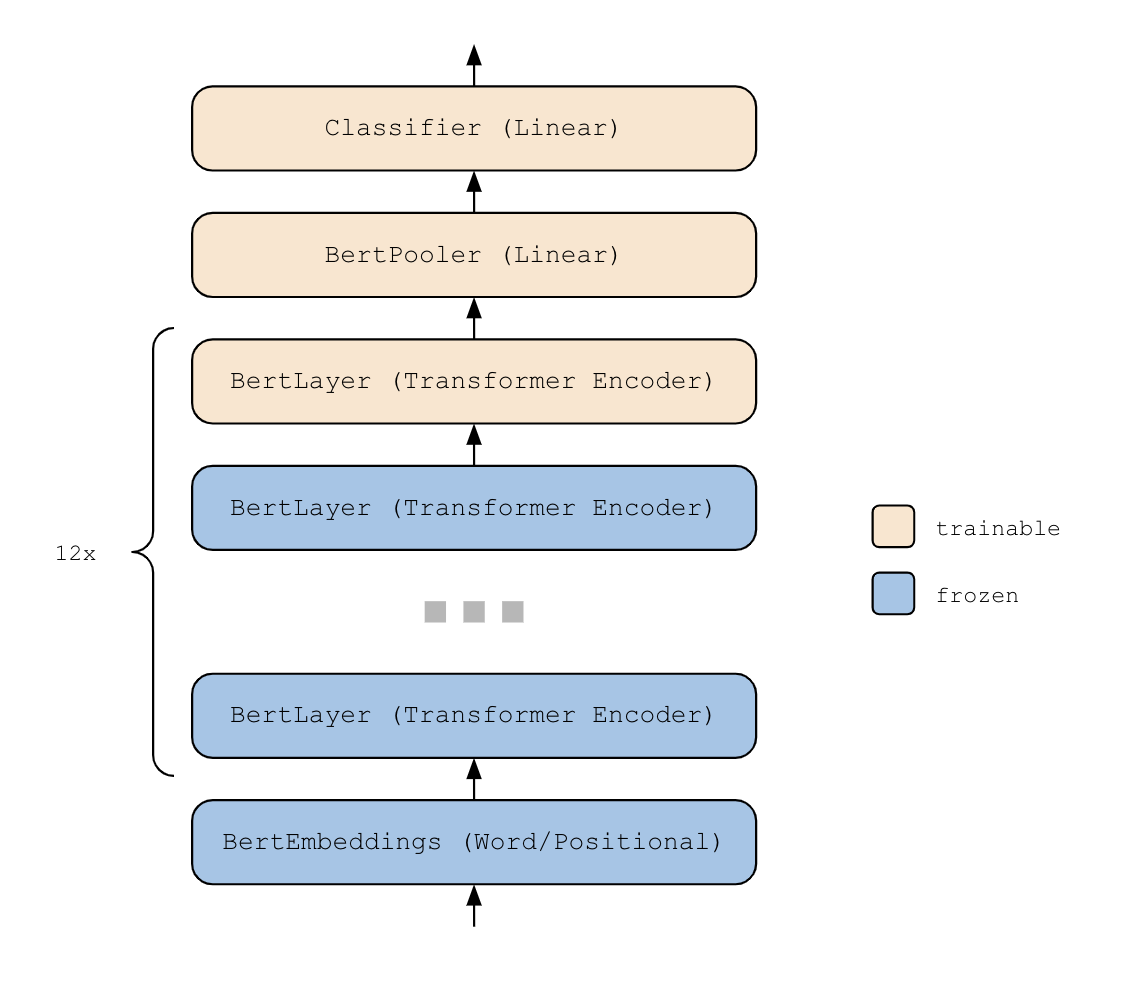

In [7]:
from IPython.display import Image
Image(filename='img/BERT.png')

In [8]:
trainable_layers = [model.bert.encoder.layer[-1], model.bert.pooler, model.classifier]
total_params = 0
trainable_params = 0

for p in model.parameters():
        p.requires_grad = False
        total_params += p.numel()

for layer in trainable_layers:
    for p in layer.parameters():
        p.requires_grad = True
        trainable_params += p.numel()

print(f"Total parameters count: {total_params}") # ~108M
print(f"Trainable parameters count: {trainable_params}") # ~7M

Total parameters count: 108312579
Trainable parameters count: 7680771


Thus, by using pre-trained model we reduce the number of trainable params from over 100 millions to just above 7.5 millions. This will help both performance and convergence with added noise.

## Prepare the data

Before we begin training, we need to preprocess the data and convert it to the format our model expects. 

(Note: it'll take 5-10 minutes to run on a laptop)

In [ ]:
LABEL_LIST = ['contradiction', 'entailment', 'neutral']
MAX_SEQ_LENGHT = 128

import torch
import transformers
from torch.utils.data import TensorDataset
from transformers.data.processors.utils import InputExample
from transformers.data.processors.glue import glue_convert_examples_to_features


def _create_examples(df, set_type):
    """ Convert raw dataframe to a list of InputExample. Filter malformed examples
    """
    examples = []
    for index, row in df.iterrows():
        if row['gold_label'] not in LABEL_LIST:
            continue
        if not isinstance(row['sentence1'], str) or not isinstance(row['sentence2'], str):
            continue
            
        guid = f"{index}-{set_type}"
        examples.append(
            InputExample(guid=guid, text_a=row['sentence1'], text_b=row['sentence2'], label=row['gold_label']))
    return examples

def _df_to_features(df, set_type):
    """ Pre-process text. This method will:
    1) tokenize inputs
    2) cut or pad each sequence to MAX_SEQ_LENGHT
    3) convert tokens into ids
    
    The output will contain:
    `input_ids` - padded token ids sequence
    `attention mask` - mask indicating padded tokens
    `token_type_ids` - mask indicating the split between premise and hypothesis
    `label` - label
    """
    examples = _create_examples(df, set_type)
    
    #backward compatibility with older transformers versions
    legacy_kwards = {}
    from packaging import version
    if version.parse(transformers.__version__) < version.parse("2.9.0"):
        legacy_kwards = {
            "pad_on_left": False,
            "pad_token": tokenizer.convert_tokens_to_ids([tokenizer.pad_token])[0],
            "pad_token_segment_id": 0,
        }
    
    return glue_convert_examples_to_features(
        examples=examples,
        tokenizer=tokenizer,
        label_list=LABEL_LIST,
        max_length=MAX_SEQ_LENGHT,
        output_mode="classification",
        **legacy_kwards,
    )

def _features_to_dataset(features):
    """ Convert features from `_df_to_features` into a single dataset
    """
    all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    all_attention_mask = torch.tensor(
        [f.attention_mask for f in features], dtype=torch.long
    )
    all_token_type_ids = torch.tensor(
        [f.token_type_ids for f in features], dtype=torch.long
    )
    all_labels = torch.tensor([f.label for f in features], dtype=torch.long)
    dataset = TensorDataset(
        all_input_ids, all_attention_mask, all_token_type_ids, all_labels
    )

    return dataset

train_features = _df_to_features(df_train, "train")
test_features = _df_to_features(df_test, "test")

train_dataset = _features_to_dataset(train_features)
test_dataset = _features_to_dataset(test_features)

## Choosing batch size

Let's talk about batch sizes for a bit.

In addition to all the considerations you normally take into account when choosing batch size, training model with DP adds another one - privacy cost. 

Because of the threat model we assume and the way we add noise to the gradients, larger batch sizes (to a certain extent) generally help convergence. We add the same amount of noise to each gradient update (scaled to the norm of one sample in the batch) regardless of the batch size. What this means is that as the batch size increases, the relative amount of noise added decreases. while preserving the same epsilon guarantee. 

You should, however, keep in mind that increasing batch size has its price in terms of epsilon, which grows at `O(sqrt(batch_size))` as we train (therefore larger batches make it grow faster). The good strategy here is to experiment with multiple combinations of `batch_size` and `noise_multiplier` to find the one that provides best possible quality at acceptable privacy guarantee.

There's another side to this - memory. Opacus computes and stores *per sample* gradients, so for every normal gradient, Opacus will store `n=batch_size` per-sample gradients on each step, thus increasing the memory footprint by at least `O(batch_size)`. In reality, however, the peak memory requirement is `O(batch_size^2)` compared to non-private model. This is because some intermediate steps in per sample gradient computation involve operations on two matrices, each with batch_size as one of the dimensions.

The good news is, we can pick the most appropriate batch size, regardless of memory constrains. Opacus has built-in support for *virtual* batches. Using it we can separate physical steps (gradient computation) and logical steps (noise addition and parameter updates): use larger batches for training, while keeping memory footprint low. Below we will specify two constants:

- `BATCH_SIZE` defines the maximum batch size we can afford from a memory standpoint, and only affects computation speed
- `VIRTUAL_BATCH_SIZE`, on the other hand, is equivalent to normal batch_size in the non-private setting, and will affect convergence and privacy guarantee.



In [10]:
BATCH_SIZE = 8
VIRTUAL_BATCH_SIZE = 32
assert VIRTUAL_BATCH_SIZE % BATCH_SIZE == 0 # VIRTUAL_BATCH_SIZE should be divisible by BATCH_SIZE
N_ACCUMULATION_STEPS = int(VIRTUAL_BATCH_SIZE / BATCH_SIZE)

In [11]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from opacus.utils.uniform_sampler import UniformWithReplacementSampler

SAMPLE_RATE = BATCH_SIZE / len(train_dataset)

train_sampler=UniformWithReplacementSampler(
    num_samples=len(train_dataset),
    sample_rate=SAMPLE_RATE,
)
train_dataloader = DataLoader(train_dataset, batch_sampler=train_sampler)

test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=BATCH_SIZE)

## Training

In [12]:
import torch

# Move the model to appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Set the model to train mode (HuggingFace models load in eval mode)
model = model.train()
# Define optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, eps=1e-8)

First we specify some training parameters ready to run the training loop for three epochs

In [15]:
EPOCHS = 3
LOGGING_INTERVAL = 1000 # once every how many steps we run evaluation cycle and report metrics
EPSILON = 7.5
DELTA = 1 / len(train_dataloader) # Parameter for privacy accounting. Probability of not achieving privacy guarantees

Let’s now define the evaluation cycle.

In [14]:
import numpy as np
from tqdm.notebook import tqdm

def accuracy(preds, labels):
    return (preds == labels).mean()

# define evaluation cycle
def evaluate(model):    
    model.eval()

    loss_arr = []
    accuracy_arr = []
    
    for batch in test_dataloader:
        batch = tuple(t.to(device) for t in batch)

        with torch.no_grad():
            inputs = {'input_ids':      batch[0],
                      'attention_mask': batch[1],
                      'token_type_ids': batch[2],
                      'labels':         batch[3]}

            outputs = model(**inputs)
            loss, logits = outputs[:2]
            
            preds = np.argmax(logits.detach().cpu().numpy(), axis=1)
            labels = inputs['labels'].detach().cpu().numpy()
            
            loss_arr.append(loss.item())
            accuracy_arr.append(accuracy(preds, labels))
    
    model.train()
    return np.mean(loss_arr), np.mean(accuracy_arr)

Next we will define and attach PrivacyEngine. There are two parameters you need to consider here:

- `noise_multiplier`. It defines the trade-off between privacy and accuracy. Adding more noise will provide stronger privacy guarantees, but will also hurt model quality.  In this run, the PrivacyEngine will determine this value based on the target values of `EPSILON`, `DELTA` and `EPOCHS`.  For the default settings, this will set `noise_multiplier` to about 0.4. 
- `max_grad_norm`. Defines the maximum magnitude of L2 norms to which we clip per sample gradients. There is a bit of tug of war with this threshold: on the one hand, a low threshold means that we will clip many gradients, hurting convergence, so we might be tempted to raise it. However, recall that we add noise with `std=noise_multiplier * max_grad_norm` so we will pay for the increased threshold with more noise. In most cases you can rely on the model being quite resilient to clipping (after the first few iterations your model will tend to adjust so that its gradients stay below the clipping threshold), so you can often just keep the default value (`=1.0`) and focus on tuning `batch_size` and `noise_multiplier` instead. That being said, sometimes clipping hurts the model so it may be worth experimenting with different clipping thresholds, like we are doing in this tutorial.

These two parameters define the scale of the noise we add to gradients: the noise will be sampled from a Gaussian distribution with `std=noise_multiplier * max_grad_norm`.


In [13]:
from opacus import PrivacyEngine

MAX_GRAD_NORM = 0.1

privacy_engine = PrivacyEngine(
    module=model,
    sample_rate=SAMPLE_RATE * N_ACCUMULATION_STEPS,
    target_delta = DELTA,
    target_epsilon = EPSILON, 
    epochs = EPOCHS,
    max_grad_norm=MAX_GRAD_NORM,
)
privacy_engine.attach(optimizer)

Now we can train the model.

In [ ]:
for epoch in range(1, EPOCHS+1):
    losses = []
    for step, batch in enumerate(tqdm(train_dataloader)):
        
        batch = tuple(t.to(device) for t in batch)
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'token_type_ids': batch[2],
                  'labels':         batch[3]}

        outputs = model(**inputs) # output = loss, logits, hidden_states, attentions
        
        loss = outputs[0]
        loss.backward()
        
        losses.append(loss.item())

        # We process small batches of size BATCH_SIZE, 
        # until they're accumulated to a batch of size VIRTUAL_BATCH_SIZE.
        # Only then we make a real `.step()` and update model weights
        if (step + 1) % N_ACCUMULATION_STEPS == 0 or step == len(train_dataloader) - 1:
            optimizer.step()
        else:
            optimizer.virtual_step()

        if step > 0 and step % LOGGING_INTERVAL == 0:
            train_loss = np.mean(losses)
            eps, alpha = optimizer.privacy_engine.get_privacy_spent(DELTA)

            eval_loss, eval_accuracy = evaluate(model)

            print(
                f"Epoch: {epoch} | "
                f"Step: {step} | "
                f"Train loss: {train_loss:.3f} | "
                f"Eval loss: {eval_loss:.3f} | "
                f"Eval accuracy: {eval_accuracy:.3f} | "
                f"ɛ: {eps:.2f} (α: {alpha})"
            )

For the test accuracy, after training for three epochs you should expect something close to the results below.

You can see that we can achieve quite strong privacy guarantee at epsilon=7.5 with a moderate accuracy cost of 11 percentage points compared to non-private model trained in a similar setting (upper layers only) and 16 points compared to best results we were able to achieve using the same architecture.

*NB: When not specified, DP-SGD is trained with upper layers only*

| Model | Noise multiplier | Batch size | Accuracy | Epsilon |
| --- | --- | --- | --- | --- |
| no DP, train full model | N/A | 32 | 90.1% | N/A |
| no DP, train upper layers only | N/A | 32 | 85.4% | N/A |
| DP-SGD | 1.0 | 32 | 70.5% | 0.7 |
| **DP-SGD (this tutorial)** | **0.4** | **32** | **74.3%** | **7.5** |
| DP-SGD | 0.3 | 32 | 75.8% | 20.7 |
| DP-SGD | 0.1 | 32 | 78.3% | 2865 |
| DP-SGD | 0.4 | 8 | 67.3% | 5.9 |